In [2]:
import numpy as np
import numpy.linalg as LA
import scipy.constants as const
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
# %matplotlib ipympl


import sys
sys.path.append('E:/google-drive/py_projects/satellites/src')
import satellites as sat


In [4]:


XHAT  = np.reshape( [1,0,0], [1,3])
YHAT  = np.reshape( [0,1,0], [1,3])
ZHAT  = np.reshape( [0,0,1], [1,3])

dist1 = sat.EARTH_RADIUS_M + 1000
vel1 = 7904.76692
mass1 = 100

npts = 7
rng = np.random.default_rng( seed = 123 )

rdilate = rng.uniform(0.9, 1.3, [npts,1])
phi = const.pi * rng.uniform(0, 2, [npts,1])
theta = const.pi * rng.uniform(0.25, 0.55, [npts,1])
velang = np.deg2rad( rng.uniform( 0, 3, [npts,1] ))

rvec = rdilate * (
        np.cos(phi)*np.sin(theta)*XHAT
    + np.sin(phi)*np.sin(theta)*YHAT
    + np.cos(theta)*ZHAT
    )
thvec = (
        -np.sin(phi)*np.sin(theta)*XHAT
    + np.cos(phi)*np.sin(theta)*YHAT
    + np.cos(theta)*ZHAT
    )

sats = []
for r,th,va in zip(rvec, thvec, velang):
    rot = Rotation.from_rotvec( va * ZHAT )
    sats.append(
        sat.GravityObject( 
            xyz_m = dist1 * r,
            vxyz_mps = rot.as_matrix() @ (vel1*th),
            mass_kg=mass1
        )
    )

esys = sat.EarthSystem( delta_time_s=2 )
for s in sats:
    esys.add_object( s )

esys.init_snapshots()

for i in range(20):
    esys.propagate_step()
    
r = np.stack(esys.positions)
v = np.stack(esys.velocities)
a = np.stack(esys.accels)

AttributeError: 'EarthSystem' object has no attribute 'init_snapshot'

In [4]:
-1.5*-1.08e-3

0.00162

In [2]:
class GravityObject():
    def __init__(self, xyz_m:list=[0,0,0], vxyz_mps:list=[0,0,0], mass_kg:float=1 ):
        self.position = np.array( xyz_m ).reshape([1,3])
        self.velocity = np.array( vxyz_mps ).reshape([1,3])
        self.mass = mass_kg


EARTH_MASS_KG = 5.9722e24
EARTH_RADIUS_M = 6378137.0
MOON_MASS_KG = 7.346e22
EARTH_MOON_DIST_M = 384784000

In [23]:
const.G * EARTH_MASS_KG

398602544600000.0

In [ ]:
3.98600441889e14

In [3]:
m_1 = 100
d_1 = 1000
f = const.G*EARTH_MASS_KG * m_1 / (EARTH_RADIUS_M + d_1)**2
v_1 = np.sqrt( (EARTH_RADIUS_M+d_1) * f / m_1 )
print(f'gravitational force = {f:0.5f} N')
print(f'speed to maintain orbit = {v_1:0.5f} m/s')

gravitational force = 979.52654 N
speed to maintain orbit = 7904.76692 m/s


In [4]:
class EarthSystem():
    def __init__(self, delta_time_s:float=1.0):
        self.objects = []
        self.positions = None
        self.velocities = None
        self.accels = None
        self.masses = None

        self.delta_time_s = delta_time_s

    def add_object(self, gravobj:GravityObject ):
        self.objects.append(gravobj)
    
    def init_snapshot(self):
        if not self.objects:
            return 1
        
        nobj = len(self.objects)
        self.positions = [np.zeros( [nobj, 3] )]
        self.velocities = [np.zeros( [nobj, 3] )]
        self.accels = [np.zeros( [nobj, 3] )]
        self.masses = np.zeros( [nobj, 1] )

        for i,o in enumerate(self.objects):
            self.positions[0][i,:] = np.array( o.position )
            self.velocities[0][i,:] = np.array( o.velocity )
            self.accels[0][i,:] = self.calc_gravity_accel( o.position )
            self.masses[i,:] = np.array( o.mass )

        return 0
    
    def add_snapshot( self, pos_new, vel_new, accel_new ):
        if (self.positions is None) or (self.velocities is None):
            raise ValueError("Please initialize the position and velocity arrays for the objects.")
        self.positions.append( pos_new )
        self.velocities.append( vel_new )
        self.accels.append( accel_new )

    def calc_gravity_accel(self, xyz ):
        distances = LA.norm( xyz, ord=2, axis=1 ).reshape([-1,1])
        grav_accel = -const.G * EARTH_MASS_KG * xyz / distances**3
        return grav_accel
        
    def calc_init_states( self ):
        no_objects_present = self.init_snapshot()
        if no_objects_present: 
            raise ValueError("No objects present. Exiting time-step propagation.")
            
        a0 = self.accels[0]
        v0 = self.velocities[0]
        r0 = self.positions[0]

        r1 = r0 + v0*self.delta_time_s + 0.5*a0*self.delta_time_s**2
        v1 = v0 + a0*self.delta_time_s
        a1 = self.calc_gravity_accel( r1 )

        self.add_snapshot( r1, v1, a1 )

    def propagate_step( self ):
        # Velocity Verlet step
        r_new = self.positions[-1] + self.velocities[-1]*self.delta_time_s + 0.5*self.accels[-1]*self.delta_time_s**2
        a_new = self.calc_gravity_accel( r_new )
        v_new = self.velocities[-1] + 0.5*( self.accels[-1] + a_new )*self.delta_time_s

        self.add_snapshot( r_new, a_new, v_new )
        



    

In [18]:
dist1 = EARTH_RADIUS_M + 1000
vel1 = 7904.76692
mass1 = 100

sats = [
    GravityObject( [dist1, 0, 10], [0, vel1, 0], mass1 ),
    GravityObject( [0, dist1, 0], [ -vel1, 0, 0], mass1 ),
    GravityObject( [-dist1, 0, 110], [ 0, -vel1, 0], mass1 ),
    GravityObject( [0, -dist1, 220], [ vel1, 0, 0], mass1 ),
]

XHAT  = np.reshape( [1,0,0], [1,3])
YHAT  = np.reshape( [0,1,0], [1,3])
ZHAT  = np.reshape( [0,0,1], [1,3])

rng = np.random.default_rng( seed = 123 )
npts = 1200
dilate = rng.uniform(0.9, 1.3, npts)
thetas = rng.uniform(0, 2*const.pi, [npts,1])
sats = []
for dil,th in zip(dilate,thetas):
    rhat_ = np.cos(th)*XHAT + np.sin(th)*YHAT
    sats.append(
        GravityObject( 
            xyz_m = dist1 * dil* rhat_,
            vxyz_mps = vel1 * LA.cross( rhat_, -ZHAT ),
            mass_kg=mass1
        )
    )


In [19]:
rdilate = rng.uniform(0.9, 1.3, [npts,1])
phi = rng.uniform(0, 2*const.pi, [npts,1])
theta = rng.uniform(0, 0.5*const.pi, [npts,1])
velang = np.deg2rad( rng.uniform( 0, 30, [npts,1] ))

rvec = rdilate * (
        np.cos(phi)*np.sin(theta)*XHAT
    + np.sin(phi)*np.sin(theta)*YHAT
    + np.cos(theta)*ZHAT
    )

In [7]:
rvec

array([[ 0.19952699, -0.6552534 ,  0.69209262],
       [ 0.40267464, -0.45546409,  0.67168849],
       [-0.06628341,  0.20647785,  1.06663207],
       [-0.462179  , -0.07929356,  1.09512211],
       [ 0.00570502,  0.00274997,  1.26742437],
       [-0.56147342, -0.32372049,  0.95023364],
       [ 0.07560598,  0.99307878,  0.78293342],
       [ 0.07274289, -0.77142011,  0.97561608],
       [ 0.44054839,  0.84655213,  0.2528701 ],
       [-0.39447439,  0.94826033,  0.70628062],
       [ 0.4819551 ,  0.04395305,  1.08966442],
       [ 0.94676855,  0.19638848,  0.29576569]])

In [20]:

esys = EarthSystem( delta_time_s=2 )
for s in sats:
    esys.add_object( s )

esys.init_snapshot()
esys.calc_init_states()
for i in range(9309):
    esys.propagate_step()
    

In [21]:
r = np.stack(esys.positions)
v = np.stack(esys.velocities)
a = np.stack(esys.accels)
r.shape

(9311, 1200, 3)

(9311,)
(9311,)


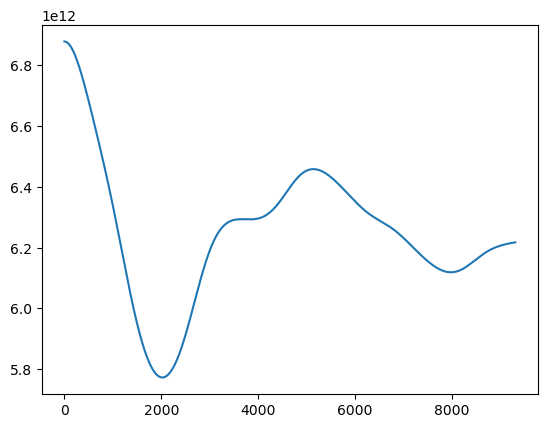

In [22]:
rnorm = LA.norm(r, ord=2, axis=2)
vnorm = LA.norm(v, ord=2, axis=2)

energy_gravity = np.sum( const.G * EARTH_MASS_KG * esys.masses.T / rnorm, axis=1 )
energy_kinetic = 0.5 * np.sum( esys.masses.T * vnorm**2, axis=1 )

print(energy_gravity.shape)
print(energy_kinetic.shape)

fig, ax = plt.subplots(1,1)

ax.plot( energy_kinetic[2:]+energy_gravity[2:])
plt.show()

In [ ]:
import pyvista as pv
pv.OFF_SCREEN = True

plotter = pv.Plotter(off_screen=True)
cloud = pv.PolyData(r[0] / EARTH_RADIUS_M)
cloud['dilate'] = dilate
plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=6, cmap='viridis')
# plotter.enable_eye_dome_lighting()
plotter.open_movie("orbits.mp4", framerate=35)

for k in range(0, len(r), 31):   # downsample frames
    cloud.points = r[k] / EARTH_RADIUS_M 
    plotter.write_frame(  )

plotter.close()



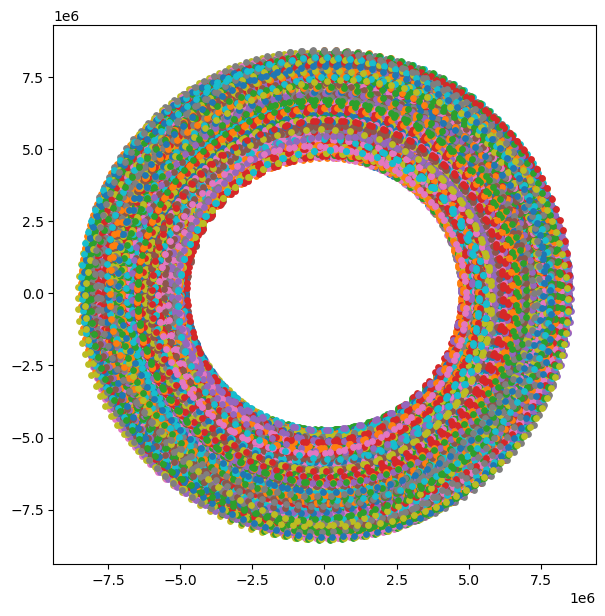

In [22]:
fig, ax = plt.subplots(1,1,figsize=[7,7])
for i,s in enumerate(sats):
    ax.scatter( r[::30,i,0], r[::30,i,1], s=15 )
